In [1]:
import pickle as pkl
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

## Calculate weights of PCA components

In [2]:
arr = []
for file in glob.glob('/global/cfs/projectdirs/desi/users/sgontcho/desiztf/highz_latents/*'):
    with open(file, 'rb') as f:
        x = pkl.load(f)
        arr.append(x)
data = np.concatenate(arr)
print(data.shape)

(20480, 10)


In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
pca.fit(data)
print(pca.explained_variance_ratio_)

[0.5107402  0.18422066 0.13344733 0.05445719 0.04244668 0.03539792
 0.02405743 0.01020646 0.00411084 0.00091525]


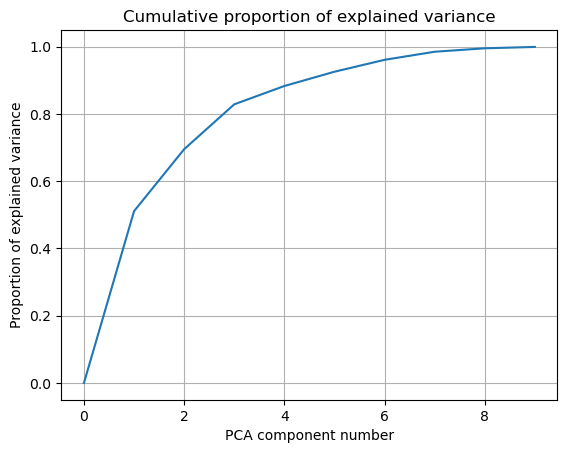

In [4]:
cumulative_var = [np.sum(pca.explained_variance_ratio_[0:i]) for i in range(10)]
plt.plot(range(0, 10), cumulative_var)
plt.xlabel("PCA component number")
plt.ylabel("Proportion of explained variance")
plt.title("Cumulative proportion of explained variance")
plt.grid()
plt.show()

## Combining latents with magnitude

In [5]:
import pickle
import numpy as np

targetids = []
all_latents = []
for ibatch in range(20):
    with open('/global/cfs/projectdirs/desi/users/sgontcho/lya/spender-lya/highz_iron_qso/data/DESIqso_highz_%i.pkl' % ibatch, "rb") as f:
        spec, w, z, target_id, norm, zerr = pickle.load(f)
        targetids += target_id.tolist()
    with open('/global/cfs/projectdirs/desi/users/sgontcho/lya/spender-lya/highz_iron_qso/latents/v0/DESIqso_highz_%i.latents.pkl' % ibatch, "rb") as f:
        latents = pickle.load(f)
        all_latents += latents.tolist()

In [6]:
import fitsio
from astropy.table import Table
from astropy.cosmology import Planck18
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

file = "/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits"
d = Table(fitsio.read(file))

SEL = np.where((d["Z"] > 2.3) & (d["Z"] < 2.8))[0]
TARGETID = d["TARGETID"][SEL][~indice]
apr_mag_g = d["APP_MAG_G"][SEL][~indice]
apr_mag_g_err = d["APP_MAGERR_G"][SEL][~indice]
apr_mag_r = d["APP_MAG_R"][SEL][~indice]
apr_mag_r_err = d["APP_MAGERR_R"][SEL][~indice]
z_desi = d["Z"][SEL][~indice]

#compute z-corrected magnitudes
d["MU"] = Planck18.distmod(d["Z"]).value
apr_mag_g = apr_mag_g - d["MU"][SEL][~indice]

In [7]:
desi_targets = set(TARGETID)
print(f"Number of DESI targets: {len(desi_targets)}")
spender_targets = set(targetids)
print(f"Number of Spender targets: {len(spender_targets)}")

common_targets = desi_targets.intersection(spender_targets)
print(f"Number of shared targets: {len(common_targets)}")


Number of DESI targets: 157741
Number of Spender targets: 20480
Number of shared targets: 6421


In [8]:
from sklearn.decomposition import PCA
pca3 = PCA(n_components = 3)
all_latents_3 = pca3.fit_transform(all_latents)

pca_all = PCA(n_components = 10)
pca_all.fit(all_latents)
print(pca_all.explained_variance_ratio_)

[0.51074003 0.18422074 0.13344736 0.05445722 0.04244671 0.03539794
 0.02405743 0.01020647 0.00411084 0.00091526]


In [9]:
all_latents_3 = [x for _, x in sorted(zip(targetids, all_latents_3))]
spender_targetids = sorted(targetids)

apr_mag_g = [x for _, x in sorted(zip(TARGETID, apr_mag_g))]
desi_targetids = sorted(TARGETID)

all_latents_3 = [all_latents_3[x] for x in range(len(all_latents_3)) if spender_targetids[x] in common_targets]
spender_targetids = [i for i in spender_targetids if i in common_targets]
apr_mag_g = [apr_mag_g[x] for x in range(len(apr_mag_g)) if desi_targetids[x] in common_targets]
desi_targetids = [i for i in desi_targetids if i in common_targets]

latent_df = pd.DataFrame(data = all_latents_3, columns = [f"Component {i}" for i in range(1,4)])
latent_df.insert(0, "targetid", spender_targetids)

desi_df = pd.DataFrame(data = zip(desi_targetids, apr_mag_g), columns = ["targetid", "mag"])

In [10]:
desi_grp = desi_df.groupby(["targetid"])
desi_agg = desi_grp.apply(lambda x: np.average(x["mag"]))
desi_agg = desi_agg.to_frame(name = "avg_mag").reset_index()

In [11]:
latent_df.insert(0, "desi_avg_mag", desi_agg["avg_mag"])
combined_df = latent_df.drop("targetid", axis = 1)

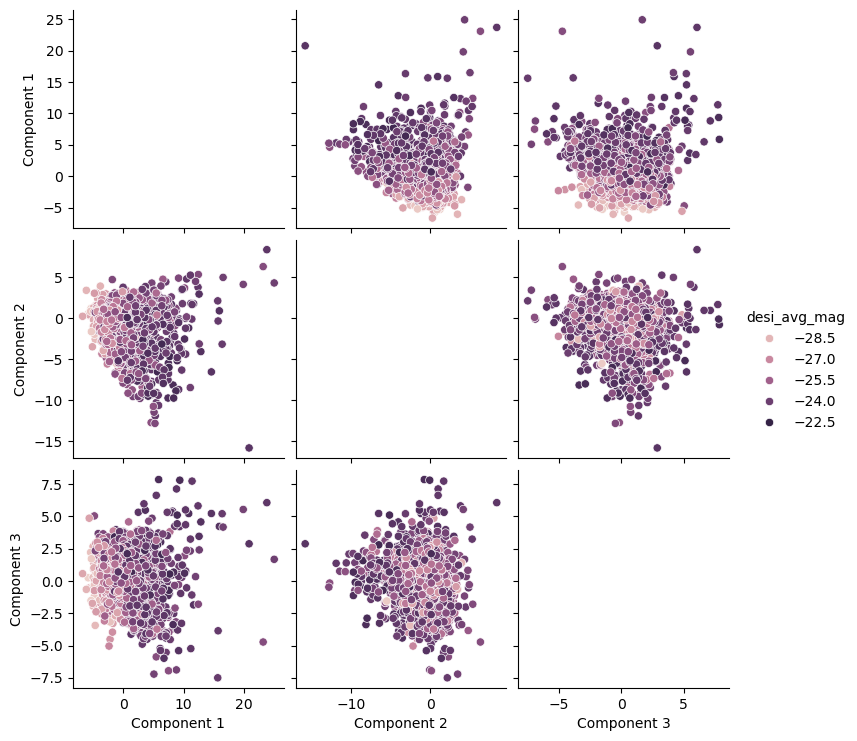

In [13]:
seaborn.pairplot(combined_df, hue = "desi_avg_mag")
plt.show()

In [14]:
print(f'Correlation between g abs mag (no k-correction) and component 1: {np.corrcoef(combined_df["desi_avg_mag"], combined_df["Component 1"])[0, 1]}')
print(f'Correlation between g abs mag (no k-correction) mag and component 2: {np.corrcoef(combined_df["desi_avg_mag"], combined_df["Component 2"])[0, 1]}')
print(f'Correlation between g abs mag (no k-correction) mag and component 3: {np.corrcoef(combined_df["desi_avg_mag"], combined_df["Component 3"])[0, 1]}')

Correlation between g abs mag (no k-correction) and component 1: 0.5230506885592737
Correlation between g abs mag (no k-correction) mag and component 2: -0.22007597256356226
Correlation between g abs mag (no k-correction) mag and component 3: 0.018412725483100984


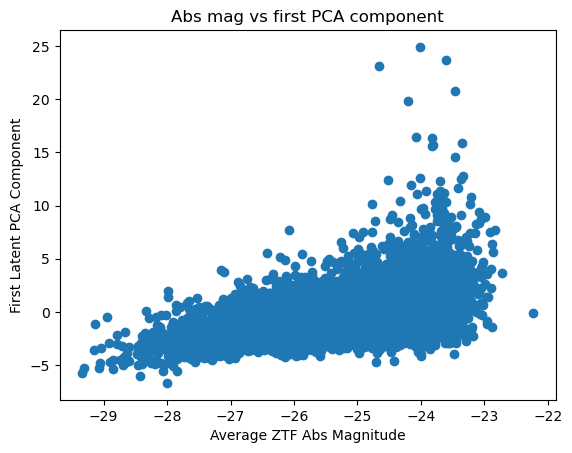

In [17]:
plt.scatter(combined_df["desi_avg_mag"], combined_df["Component 1"])
plt.xlabel("Average ZTF Abs Magnitude")
plt.ylabel("First Latent PCA Component")
plt.title("Abs mag vs first PCA component")
plt.show()

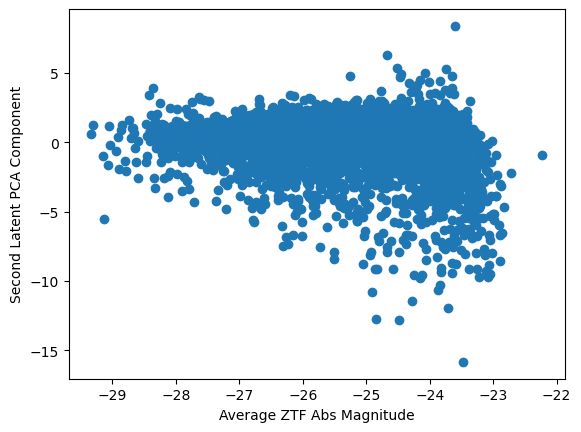

In [16]:
plt.scatter(combined_df["desi_avg_mag"], combined_df["Component 2"])
plt.xlabel("Average ZTF Abs Magnitude")
plt.ylabel("Second Latent PCA Component")
plt.title("ABs mag vs first PCA component")
plt.show()